# Preparatory code

## Imports

In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
from PIL import Image
from IPython.display import clear_output
import time

%matplotlib inline

## Setup

In [14]:
set_seed = torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4

device

device(type='cuda')

## Support functions

In [15]:
def live_plot(train_loss, val_loss, val_accuracy, figsize=(7,5), title='Model performance in training'):
        '''
        It plots only the average loss and validation per epoch.
        '''
        train_loss = train_loss.astype('float64')
        val_loss = val_loss.astype('float64')
        #val_accuracy = val_accuracy.astype('float64')
        x = np.arange(train_loss.shape[0])

        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.ylim(0, 1)

        plt.plot(x, train_loss, label = "Training loss")
        plt.plot(x, val_loss, label = "Validation loss")
        plt.plot(x, val_accuracy, label = "Validation accuracy")
        plt.legend()
        plt.show()

# Data generator

IMPORTANT: Data must be at the same level of this file, in a folder called "dataset" with three folders "train", "test", "val".

The following preprocessing was suggested by PyTorch documentation for ResNet.

In [ ]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
train_set = torchvision.datasets.ImageFolder(root="dataset/train", transform=preprocess)
test_set = torchvision.datasets.ImageFolder(root="dataset/val", transform=preprocess)

In [18]:
train_set, val_set = torch.utils.data.random_split(train_set, [0.7, 0.3])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


tensor(1)


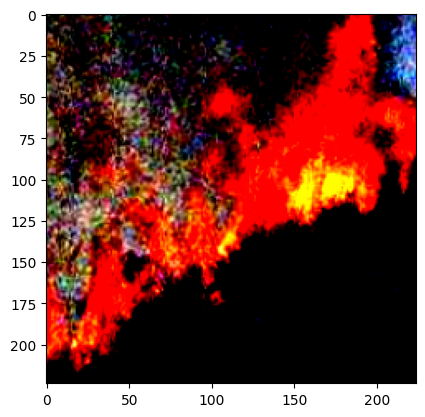

In [19]:
# Testing the dataloader
for test_images, test_labels in train_loader:  
    sample_image = test_images[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]
    break
plt.imshow(  sample_image.permute(1, 2, 0)  )
print(sample_label)

# Models


## Handmade MLP

In [20]:
class MLP(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden_units, num_hidden_layers = 1, activation = torch.nn.ReLU()):
        super().__init__()
        hiddens = [f for x in range(num_hidden_layers - 1) for f in (torch.nn.Linear(num_hidden_units, num_hidden_units), activation)]
        self.model = torch.nn.Sequential(torch.nn.Flatten(),
                                        torch.nn.Linear(in_features=num_inputs, 
                                                         out_features=num_hidden_units),
                                        activation,
                                        *hiddens,
                                        torch.nn.Linear(in_features=num_hidden_units,
                                                        out_features=num_outputs))
        
    def forward(self, x):
        return self.model(x)

## ResNet-34

Since the original ResNet-34 model outputs 1000 classes, a final bottleneck layer collpases everything in 2 classes.

In [21]:
class ResNet34(torch.nn.Module):
    def __init__(self, num_outputs):
        super(ResNet34, self).__init__()
        self.model_resnet = torchvision.models.resnet34()
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = torch.nn.Identity()
        self.fc = torch.nn.Linear(num_ftrs, num_outputs)

    def forward(self, x):
        x = self.model_resnet(x)
        out = self.fc(x)
        return out

# Trainer

In [22]:
class Trainer:
    def __init__(self, model, loss, optimizer, acc_metric, batchsize = 32, epochs = 5):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.batchsize = batchsize
        self.accuracy = acc_metric
        
    def fit_model(self, train_loader, val_loader):
        '''
        A function that optimizes the model and plots the results.
        '''
        
        train_loss = np.array([])
        val_loss = np.array([])
        val_accuracy = np.array([])

        for i in range(self.epochs):
            # Total loss and accuracies are needed for plotting
            training_total_loss = 0
            validation_total_loss = 0
            validation_total_accuracy = 0

            for j, data in enumerate(train_loader):  
                x, y = data
                x = x.to(device)
                y = y.to(device)

                # Loss computation
                self.model.train()
                self.optimizer.zero_grad()

                y_hat = self.model(x)
                loss = self.loss(y_hat, y)

                # Optimization
                loss.backward()
                self.optimizer.step()

                # Tracking total loss
                training_total_loss += loss.cpu().detach().numpy()

            train_loss = np.append(train_loss, training_total_loss/(j+1))   # this is needed for plotting
            
            # Validation
            self.model.eval()
            with torch.no_grad():
                for j, data in enumerate(train_loader):  
                    x, y = data
                    x = x.to(device)
                    y = y.to(device)

                    y_hat = self.model(x)

                    validation_total_loss += self.loss(y_hat, y).cpu().detach().numpy()
                    validation_total_accuracy += self.accuracy(y_hat, y).cpu().detach().numpy()
                
                val_loss = np.append(val_loss, validation_total_loss/(j+1))   # this is needed for plotting
                val_accuracy = np.append(val_accuracy, validation_total_accuracy/(j+1))

            # Updating the training plot
            live_plot(train_loss, val_loss, val_accuracy)

    def test_model(self, test_loader):
        '''
        A function that tests the model.
        '''
        
        test_loss = np.array([])
        test_accuracy = np.array([])

        for i, data in enumerate(test_loader):
            # Data loading  
            x, y = data
            x = x.to(device)
            y = y.to(device)

            # Loss and accuracy computation
            self.model.eval()

            with torch.no_grad():
                y_hat = self.model(x)
                loss = self.loss(y_hat, y)
                accuracy = self.accuracy(y_hat, y)
                test_loss = np.append(test_loss, loss.cpu().detach().numpy())   # this is needed for plotting
                test_accuracy = np.append(test_accuracy, accuracy.cpu().detach().numpy())

        return np.mean(test_loss), np.mean(test_accuracy)        

# Training tests


## MLP

In [23]:
# Note how model AND ACCURACY need both to be on GPU

model = MLP(num_inputs=224*224*3,
            num_hidden_units=256,
            num_hidden_layers=1,
            num_outputs=2).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.3)
loss = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=2).to(device)
trainer = Trainer(model, loss, optimizer, accuracy, epochs=10)

#trainer.fit_model(train_loader, val_loader)

## ResNet-34

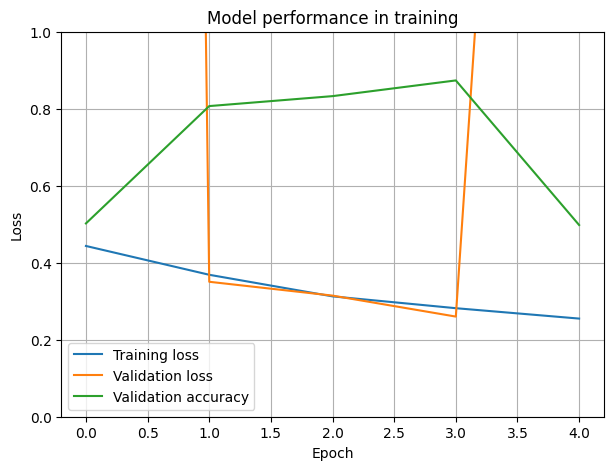

KeyboardInterrupt: 

In [25]:
# Note how model AND ACCURACY need both to be on GPU

model = ResNet34(num_outputs=2).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
loss = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=2).to(device)
trainer = Trainer(model, loss, optimizer, accuracy, epochs=10)

trainer.fit_model(train_loader, val_loader)